**Git Link:** https://github.com/paulmjojy/705.603/tree/master/FinalProj

**Docker Link:** https://hub.docker.com/layers/206116071/pjojy/class705.603/grocer_model/images/sha256-fba8abe047d7990f6fd29e9d9940f66b9a75e2c2ab689a7dd6589899a2b8687b?context=repo

# Predicting Grocery Store Demand
## Using The 6 D Framework
### Decomposition

When I was in my local Giant the other day, many aisles were empty. The only thing on the shelves which usually hold an abundance of chicken was a sign that said "Due to local supply chain challenges, certain items in the store are limited. We apologize for the inconvenience." With the pandemic showing no signs of slowing down and supply chains across the globe out of sync, how can we use AI to help? What if we were able to use AI to predict when certain items at certain locations will increase in demand, and order these items to those locations ahead of time? Or, what if we could predict which items will go out of stock soon due to supply chain challenges, and limit how much of that item each customer can take; maximizing the number of consumers that would be able to get that item? By looking at data on grocery stock and analyzing which goods have had the highest demand in the past, perhaps we can proactively limit quantities per customer or, if possible, try to order a higher quantity than usual. I would like to build a system that predicts/forecasts item demand at grocery stores based on past inventory history. Armed with this new insight, the store manager can proactively stagger when foods will hit the shelves/order an increased quantity of one item and decrease the quantity of a less demanded item to balance resources. In cloud computing, the Cloud scales resources up/down based on demand. I believe something similar can be done by the grocer.

### Domain Expertise
After proposing this idea to the professor, he posed an interesting question. Could you predict supply chain issues before they become issues - with store data alone? Research online enlightened me to the fact that customers can be unpredictable. Due to this, it's incredibly difficult to accurately forecast demand. This is because of the curse of dimensionality: at high levels of aggregation, it's easy to make estimates, but when you delve deeper into the details, there are too many confounding variables at play to make an accurate guess. If you look at the below table, you can see that the global leaders in their own sectors struggle to make accurate forecasts:
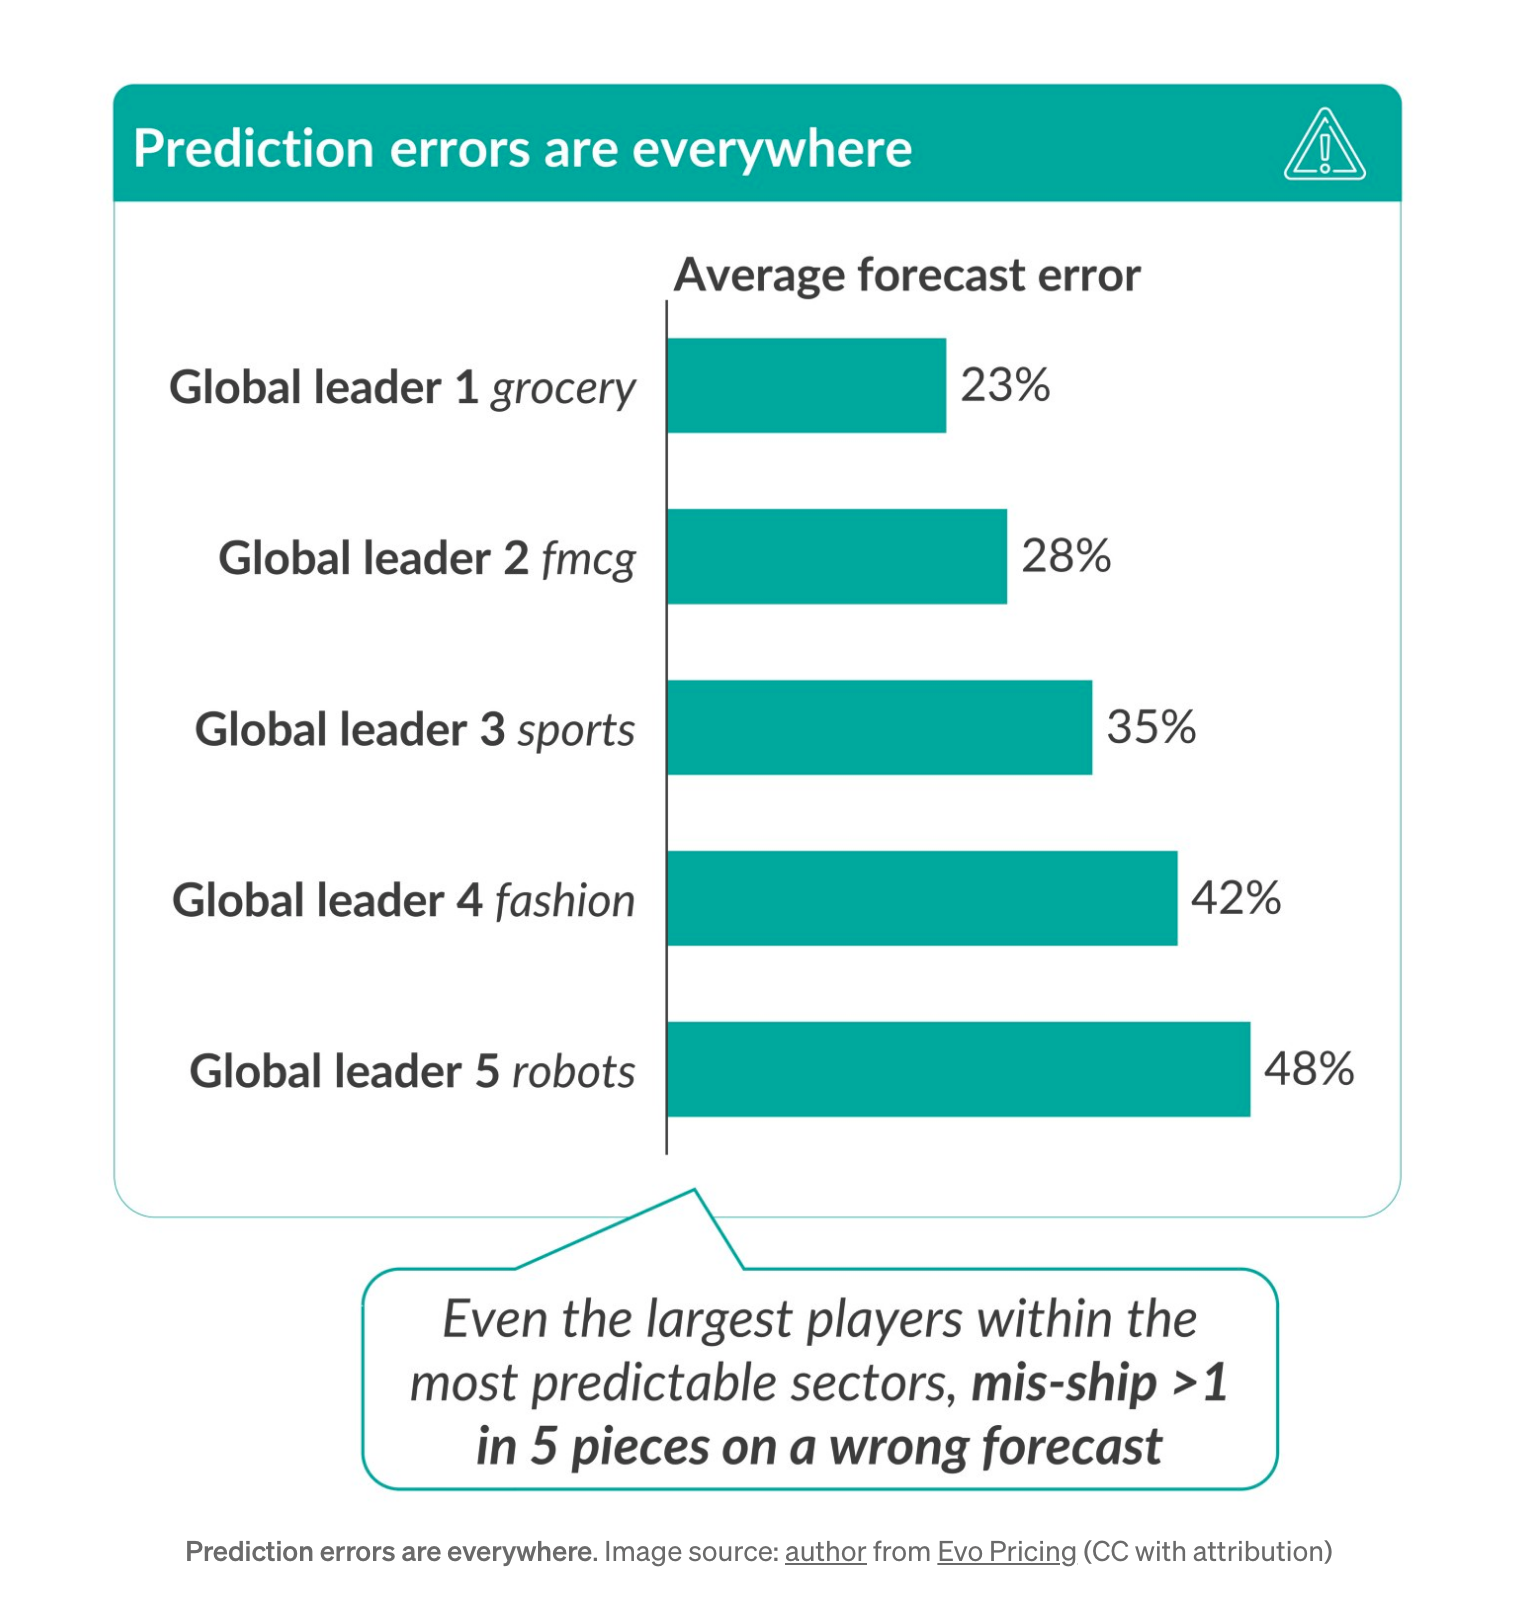

Therefore, while we can't solve supply chain issues with predicting grocery store demand, at least we may be able to identify demand issues in one grocery store before it becomes a problem, and accurately adjust business practices to prepare for the extra strain. Consulted source: https://towardsdatascience.com/to-forecast-or-not-to-forecast-that-is-the-supply-chain-question-439e0eb47b61

### Data
I was able to find grocery store data from an Ecuadorian Grocery Store chain (Corporacion Favorita) which can be used to test my idea. Ideally, the owner of the grocery store would train on their own grocery store data. 

This grocery store dataset contains the target **unit_sales** by **date**, **store_nbr**, and **item_nbr** and a unique **id** to label rows.

I also added the items dataset in order to link the **item_nbr** to the item category. 
Source: https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data?select=train.csv.7z

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
import streamlit as st
import os
import pickle

In [2]:
#load in both grocery store data and items that correspond to IDs
grocer = pd.read_csv('train.csv', parse_dates=['date'],index_col='date')
items = pd.read_csv('items.csv')

/Users/pauljojy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
grocer.dtypes
grocer.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2013-01-01,0,25,103665,7.0,NaN
2013-01-01,1,25,105574,1.0,NaN
2013-01-01,2,25,105575,2.0,NaN
2013-01-01,3,25,108079,1.0,NaN
2013-01-01,4,25,108701,1.0,NaN


Convert date to datetime type

In [4]:
grocer['year'] = grocer.index.year
grocer['month'] = grocer.index.month
grocer['day'] = grocer.index.day

Merge item names with grocery store dataframe

In [5]:
grocer = pd.merge(grocer.reset_index(), items, how = 'left').set_index('date')
del items

In [6]:
display(grocer.head())
print(grocer.columns)

,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,family,class,perishable
date,,,,,,,,,,,
2013-01-01,0,25,103665,7.0,NaN,2013,1,1,BREAD/BAKERY,2712,1
2013-01-01,1,25,105574,1.0,NaN,2013,1,1,GROCERY I,1045,0
2013-01-01,2,25,105575,2.0,NaN,2013,1,1,GROCERY I,1045,0
2013-01-01,3,25,108079,1.0,NaN,2013,1,1,GROCERY I,1030,0
2013-01-01,4,25,108701,1.0,NaN,2013,1,1,DELI,2644,1


Index(['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year',
       'month', 'day', 'family', 'class', 'perishable'],
      dtype='object')


In [7]:
# Check unique levels and see if any marker is used for a missing level
for col in grocer.columns:
    if grocer[col].dtype == object:
        print(col, grocer[col].unique())
        print(len(grocer[col].unique()))
#There seems to be a missing level, in the category 'onpromotion' so we will remove the rows with a NaN value.

onpromotion [nan False True]
3
family ['BREAD/BAKERY' 'GROCERY I' 'DELI' 'CLEANING' 'PERSONAL CARE' 'BEVERAGES'
 'DAIRY' 'EGGS' 'POULTRY' 'LINGERIE' 'PREPARED FOODS' 'GROCERY II'
 'FROZEN FOODS' 'MEATS' 'LIQUOR,WINE,BEER' 'LAWN AND GARDEN' 'BEAUTY'
 'AUTOMOTIVE' 'SEAFOOD' 'HARDWARE' 'HOME APPLIANCES' 'PRODUCE'
 'HOME AND KITCHEN II' 'HOME AND KITCHEN I' 'MAGAZINES' 'HOME CARE'
 'PET SUPPLIES' 'PLAYERS AND ELECTRONICS' 'CELEBRATION' 'LADIESWEAR'
 'SCHOOL AND OFFICE SUPPLIES' 'BABY CARE' 'BOOKS']
33


In [8]:
#Remove outliers 
up_b = grocer['unit_sales'].mean() + 2*grocer['unit_sales'].std()
low_b = grocer['unit_sales'].mean() - 2*grocer['unit_sales'].std()

grocer.loc[grocer['unit_sales'] > up_b, 'unit_sales'] = np.nan
grocer.loc[grocer['unit_sales'] < low_b, 'unit_sales'] = np.nan

In [9]:
print(f'Before dropping null rows: {grocer.shape}')
grocer = grocer.dropna()
print(f'After dropping null rows: {grocer.shape}')

Before dropping null rows: (125497040, 11)
After dropping null rows: (102183114, 11)


We still have a sufficient amount of data to work with.

In [10]:
grocer.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,family,class,perishable
date,,,,,,,,,,,
2014-04-01,21657651,1,103520,1.0,False,2014,4,1,GROCERY I,1028,0
2014-04-01,21657652,1,103665,3.0,False,2014,4,1,BREAD/BAKERY,2712,1
2014-04-01,21657653,1,105574,1.0,False,2014,4,1,GROCERY I,1045,0
2014-04-01,21657654,1,105575,11.0,False,2014,4,1,GROCERY I,1045,0
2014-04-01,21657655,1,105577,4.0,False,2014,4,1,GROCERY I,1045,0


We're only focused on one store's data, so we'll check for which store number provides the most entries. Training a model on one store's data is better than training on all, because we want to predict demand for each individual store rather than the chain as a whole. 

In [11]:
max_df = grocer.groupby(['store_nbr']).count()['perishable']
print(max_df[max_df == max(max_df)])

store_nbr
45    2717760
Name: perishable, dtype: int64


We see store 45 provides the most data, so we'll train our algorithm on this store.

In [12]:
grocer = grocer[grocer['store_nbr'] == 45]
grocer.shape

(2717760, 11)

In [13]:
grocer.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,family,class,perishable
date,,,,,,,,,,,
2014-04-01,21698735,45,103520,10.0,False,2014,4,1,GROCERY I,1028,0
2014-04-01,21698736,45,103665,2.0,False,2014,4,1,BREAD/BAKERY,2712,1
2014-04-01,21698737,45,105574,17.0,False,2014,4,1,GROCERY I,1045,0
2014-04-01,21698738,45,105575,55.0,False,2014,4,1,GROCERY I,1045,0
2014-04-01,21698739,45,105577,15.0,False,2014,4,1,GROCERY I,1045,0


We dont't need id, store_nbr, item_nbr, or class, so we'll remove those variables. 

In [14]:
grocer = grocer.drop(['id','store_nbr','class','item_nbr'],axis=1)

Since the onpromotion variable is binary, we'll change the values to binary numbers. We'll also one_hot encode Family

In [15]:
grocer['onpromotion'] = grocer['onpromotion'].astype(int)

# pandas get_dummies function is the one-hot-encoder
def encode_onehot(_df, f):
    _df2 = pd.get_dummies(_df[f], prefix='', prefix_sep='').max(level=0, axis=1).add_prefix(f+' - ')
    df3 = pd.concat([_df, _df2], axis=1)
    df3 = df3.drop([f], axis=1)
    return df3
grocer = encode_onehot(grocer,'family')

In [16]:
grocer.head()

,unit_sales,onpromotion,year,month,day,perishable,family - AUTOMOTIVE,family - BEAUTY,family - BEVERAGES,family - BOOKS,...,family - MAGAZINES,family - MEATS,family - PERSONAL CARE,family - PET SUPPLIES,family - PLAYERS AND ELECTRONICS,family - POULTRY,family - PREPARED FOODS,family - PRODUCE,family - SCHOOL AND OFFICE SUPPLIES,family - SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,10.0,0,2014,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,2.0,0,2014,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,17.0,0,2014,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,55.0,0,2014,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,15.0,0,2014,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Split train and test data
train_size = int(len(grocer)*.8)
train_set,val_set = grocer.iloc[:train_size], grocer.iloc[train_size:]

X_tr = train_set.drop('unit_sales',axis=1)
y_tr = train_set.loc[:,['unit_sales']]

X_val = val_set.drop('unit_sales',axis=1)
y_val = val_set.loc[:,['unit_sales']]

In [18]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_tr)
output_scaler = scaler_y.fit(y_tr)

#Save the scaler to use in GUI script later
pickle.dump(input_scaler, open('inpscale.sav','wb'))
pickle.dump(output_scaler, open('outscale.sav','wb'))

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_tr)
train_x_norm = input_scaler.transform(X_tr)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_val)
test_x_norm = input_scaler.transform(X_val)

In [19]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)

print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (543522, 30, 37)
y_train.shape:  (2174178, 1)
X_test.shape:  (543522, 30, 37)
y_test.shape:  (2174178, 1)


# Design

LSTMs are special RNNs that are able to retain long-term memory. Therefore, our RNN design will utilize LSTMs, since we want to use past trends to forecast future data. The below design was taken from https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02

In [20]:
model = Sequential()
model.add(LSTM(units=64, return_sequences = True, input_shape = [X_train.shape[1],X_train.shape[2]]))
model.add(Dropout(.2))
model.add(LSTM(units=64))
model.add(Dropout(.2))
model.add(Dense(units=1))

model.compile(loss='mse',optimizer='adam')

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
if os.path.exists('Grocer_Model.h5'):
    model = tf.keras.models.load_model('Grocer_Model.h5')
else:
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size = 32, 
                shuffle = False, callbacks = [early_stop])
    model.save('Grocer_Model.h5',save_format='h5')

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-04 09:00:43.589 WARNING tensorflow: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fe35b543710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54355/54355 [==============================] - ETA: 0s - loss: 0.0108WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe36e134dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-04 09:30:42.069 WARNING tensorflow: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe36e134dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54355/54355 [==============================] - 1934s 36ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 2/100
54355/54355 [==============================] - 1303s 24ms/step - loss: 0.0092 - val_loss: 0.0106
Epoch 3/100
54355/54355 [==============================] - 826s 15ms/step - loss: 0.0089 - val_loss: 0.0105
Epoch 4/100
54355/54355 [==============================] - 1259s 23ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 5/100
54355/54355 [==============================] - 7048s 130ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 6/100
54355/54355 [==============================] - 9242s 170ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 7/100
54355/54355 [=====================

# Diagnosis

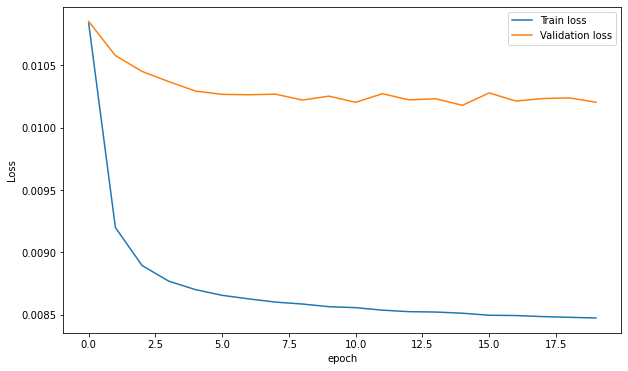

In [22]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

From this chart, we can see that val_loss is at a minimum after 10 epochs.

In [23]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [24]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [25]:
prediction = model.predict(X_test)
prediction = scaler_y.inverse_transform(prediction)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-05 12:33:48.101 WARNING tensorflow: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7ff08c53a7a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
#calculate MAE and RMSE
errors = prediction - y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
    


Mean Absolute Error: 952.0124
Root Mean Square Error: 1369.4933


This error seems a bit high. I think this is due to the lack of diverse features in my dataset. In the future, I might want to find datasets with more descriptive features.

# Deployment
## Building A User Interface

In order to fulfill one of the technology requirements of the System Project, a GUI has been created in the form of a webpage that the user can access. This webpage is created by streamlit, a python library that enables webpage creation using python. you can run the cell below to open the webpage, so long as grocer_model.py is in the same directory as this notebook. Here is a screenshot of the page:
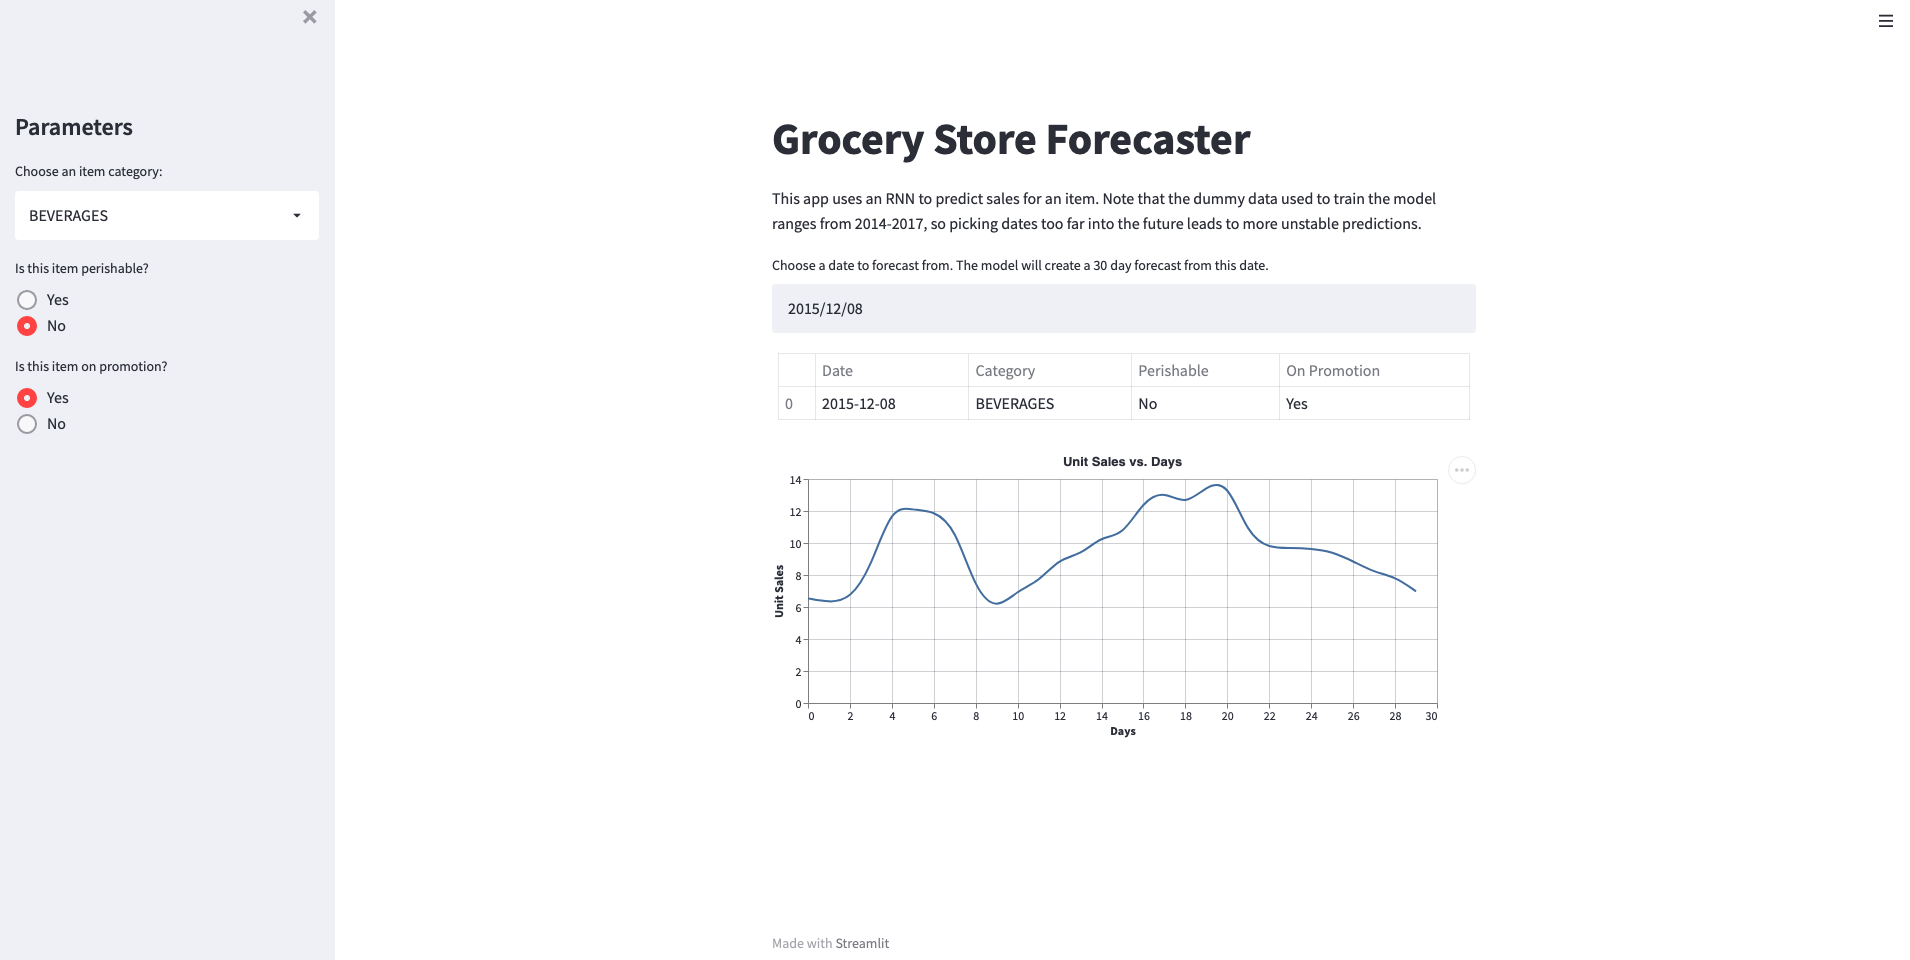

Below is another example with a different category:
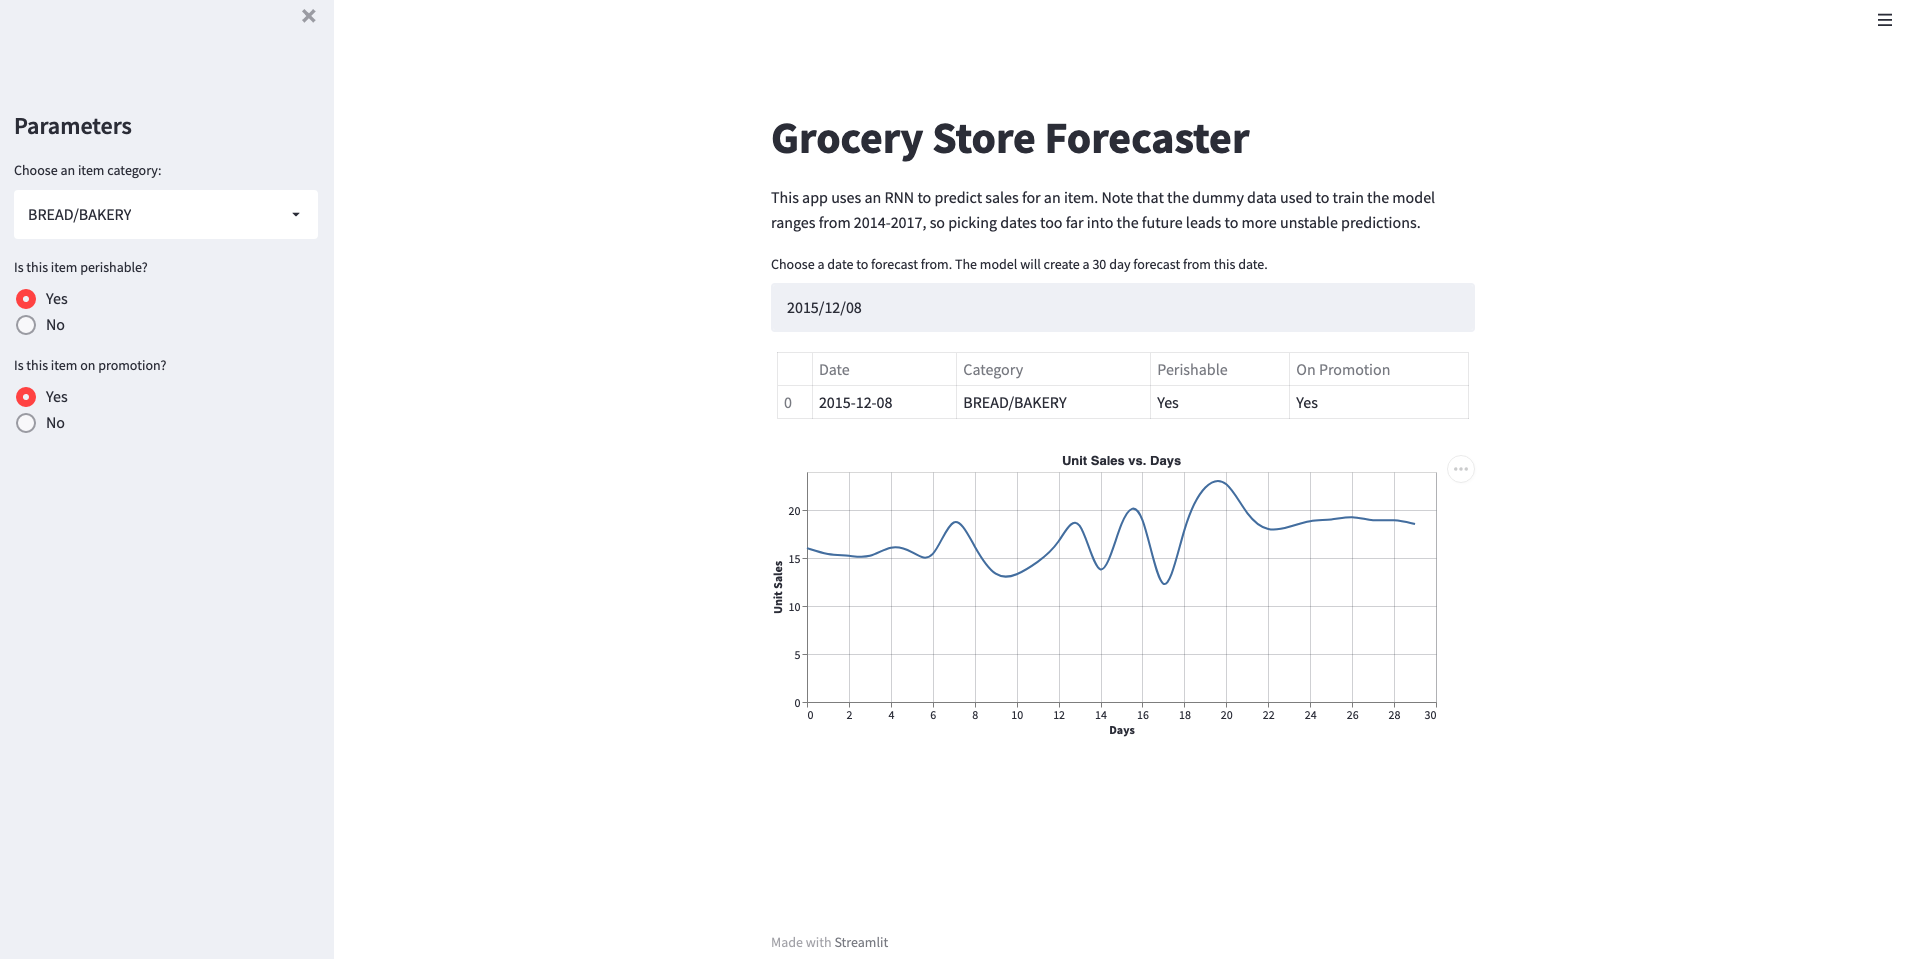

In [27]:
os.system('streamlit run grocer_model.py')

0

## Building Docker Pipeline
In order to fulfill one of the technology requirements of the System Project, A Docker pipeline has been built using the above streamlit python file. When pushes are made to git, everything is automatically pushed as an image to dockerhub as well. The github action code can be found at: https://github.com/paulmjojy/705.603/blob/master/.github/workflows/docker-image.yml

The above linked github action code will create an image that gets pushed to Dockerhub at: https://hub.docker.com/layers/206116071/pjojy/class705.603/grocer_model/images/sha256-45ab748e11f500c3c4e42bf8bcdf91f5d6cd136c8f017baebf1d10fdc1cefe21?context=repo

You can run the container using: 

**docker run -p 8501:8501 pjojy/class705.603:grocer_model** 

## References
**Research on RNNs**

https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02

https://towardsdatascience.com/to-forecast-or-not-to-forecast-that-is-the-supply-chain-question-439e0eb47b61


**Building a CI/CD pipeline**

https://dev.to/tsuki42/ci-cd-pipeline-with-docker-github-actions-dockerhub-and-watchtower-3l3n

https://medium.com/platformer-blog/lets-publish-a-docker-image-to-docker-hub-using-a-github-action-f0b17e5cceb3

https://github.com/marketplace/actions/build-and-push-docker-images

**Dataset**

https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data?select=train.csv.7z

**Running streamlit from a container**

https://www.section.io/engineering-education/how-to-deploy-streamlit-app-with-docker/